In [1]:
import sys
sys.path.append("/home/hmora/network-gen-pipeline/src")

import utils.DateUtils as du

import duckdb
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from geopandas import datasets, GeoDataFrame, read_file, GeoSeries
from pandas import concat

from shapely.geometry import shape
import shapely.wkt

import json

from h3 import h3

import matplotlib.pyplot as plt

import os
from pathlib import Path

from dotenv import load_dotenv
import os
load_dotenv()

duck = duckdb.connect("../temp/file.db")

/tmp/ipykernel_3846260/1984986331.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
YEAR, MONTH, DAY = ("2020", "01", "07")

### Obtención de ZMV

In [3]:
# Se obtienen las zonas metropolitanas con CVZ_ZM = 09.01
zonas_metropolitanas_vm = duck.sql(f"""
WITH
all_zones AS (
    SELECT *
    FROM read_csv_auto('{os.environ["ZONAS_METROPOLITANAS_2015"]}')
)

SELECT CVE_ZM AS cve_zm
    , CVE_MUN AS cve_mun
FROM all_zones
WHERE CVE_ZM = '09.01'
""").df()

In [4]:
# Se obtienen el catálogo de polígonos totales
mun_catalog = duck.sql(f"""
SELECT CONCAT(cve_agee, cve_agem) AS cve_mun
    , geometry
FROM read_parquet('{os.environ['AGEB_CATALOG']}')
""").df()

In [5]:
# Se obtienen los polígonos de las zonas metropolitanas en la ZVM
ZVM = duck.sql("""
WITH
pre AS (
    SELECT a.cve_zm, a.cve_mun, b.geometry
    FROM 
        zonas_metropolitanas_vm AS a
        LEFT JOIN
        mun_catalog AS b
        ON a.cve_mun = b.cve_mun
)

SELECT *
FROM pre
""").df()
ZVM["geometry"] = ZVM["geometry"].apply(lambda x: shape(json.loads(x)))

In [6]:
ZVM

,cve_zm,cve_mun,geometry
0,09.01,09016,"MULTIPOLYGON (((-99.21122917 19.4298056, -99.2..."
1,09.01,09015,"MULTIPOLYGON (((-99.16404172 19.4060894, -99.1..."
2,09.01,15109,"MULTIPOLYGON (((-99.18728388 19.58904478, -99...."
3,09.01,09005,"MULTIPOLYGON (((-99.08879198 19.47500166, -99...."
4,09.01,15031,"MULTIPOLYGON (((-98.95457178 19.41445346, -98...."
...,...,...,...
6053,09.01,09007,"MULTIPOLYGON (((-99.05376251 19.347039801, -99..."
6054,09.01,09007,"MULTIPOLYGON (((-98.99044098 19.34507778, -98...."
6055,09.01,09014,"MULTIPOLYGON (((-99.18465445 19.37473385, -99...."
6056,09.01,09014,"MULTIPOLYGON (((-99.132397819 19.3911572, -99...."


In [7]:
# Se confirma que todos los municipios en el csv esten en el df obtenido
assert len(ZVM.cve_mun.unique()) == len(zonas_metropolitanas_vm["cve_mun"])
# Se verifica que todos los registros tengan su polígono asociado
assert (ZVM[ZVM["geometry"].isnull()]).empty

### Lectura de pings en 2020-01-07

In [8]:
# Se obtiene un intervalo de fechas que comprenda 
# 10 días alrededor de la fecha de interés
dates = du.trusted_range(YEAR, MONTH, DAY, 10)
dates

2020-01-02 <--2020-01-07--> 2020-01-12


[datetime.datetime(2020, 1, 2, 0, 0),
 datetime.datetime(2020, 1, 3, 0, 0),
 datetime.datetime(2020, 1, 4, 0, 0),
 datetime.datetime(2020, 1, 5, 0, 0),
 datetime.datetime(2020, 1, 6, 0, 0),
 datetime.datetime(2020, 1, 7, 0, 0),
 datetime.datetime(2020, 1, 8, 0, 0),
 datetime.datetime(2020, 1, 9, 0, 0),
 datetime.datetime(2020, 1, 10, 0, 0),
 datetime.datetime(2020, 1, 11, 0, 0),
 datetime.datetime(2020, 1, 12, 0, 0)]

In [9]:
# Se leen los dataframes correspondientes al rango de fechas anterior y se seleccionan 
# aquellos registros que presentan la fecha de interés y horizontal_accuracy >= 100
dfs = []

for d in dates:
    curr_path = \
        f"{os.environ[f'MOVILIDAD_RAW_{YEAR}']}/month={str(d.month).zfill(2)}/day={str(d.day).zfill(2)}"

    print(curr_path)

    result = duck.sql(f"""
    WITH
    raw_data AS (
        SELECT *
        FROM read_parquet('{curr_path}/*')
    )

    , with_cdmx_datetime AS (
        SELECT *
            , TIMEZONE('America/Mexico_City', TO_TIMESTAMP(utc_timestamp)) AS cdmx_datetime
        FROM raw_data
    )

    SELECT utc_timestamp, cdmx_datetime, caid
        , latitude, longitude, horizontal_accuracy
    FROM with_cdmx_datetime
    WHERE STRFTIME(cdmx_datetime, '%Y-%m-%d') = '{YEAR}-{MONTH}-{DAY}'
        AND horizontal_accuracy >= 100 -- AQUÍ HAY UN FILTRO
    """).df()

    if not result.empty:
        dfs.append(result)

big_union = pd.concat(dfs)
big_union = big_union.drop_duplicates()

/datos/botanero/botanero/aws/movement_parquet/year=2020/month=01/day=02
/datos/botanero/botanero/aws/movement_parquet/year=2020/month=01/day=03
/datos/botanero/botanero/aws/movement_parquet/year=2020/month=01/day=04
/datos/botanero/botanero/aws/movement_parquet/year=2020/month=01/day=05
/datos/botanero/botanero/aws/movement_parquet/year=2020/month=01/day=06
/datos/botanero/botanero/aws/movement_parquet/year=2020/month=01/day=07
/datos/botanero/botanero/aws/movement_parquet/year=2020/month=01/day=08
/datos/botanero/botanero/aws/movement_parquet/year=2020/month=01/day=09
/datos/botanero/botanero/aws/movement_parquet/year=2020/month=01/day=10
/datos/botanero/botanero/aws/movement_parquet/year=2020/month=01/day=11
/datos/botanero/botanero/aws/movement_parquet/year=2020/month=01/day=12


In [10]:
big_union

,utc_timestamp,cdmx_datetime,caid,latitude,longitude,horizontal_accuracy
0,1578368282,2020-01-07 09:38:02+00:00,212a38f3fc9aa200477b03b31bb0a4b55d08a2652e294e...,21.052160,-89.630840,112.000000
1,1578368331,2020-01-07 09:38:51+00:00,212a38f3fc9aa200477b03b31bb0a4b55d08a2652e294e...,21.052150,-89.630830,112.000000
2,1578371330,2020-01-07 10:28:50+00:00,d66445e78dfe7c118770a1b013723360992896d8bea435...,21.053164,-89.630510,142.000000
3,1578371333,2020-01-07 10:28:53+00:00,d66445e78dfe7c118770a1b013723360992896d8bea435...,21.053164,-89.630510,142.500000
4,1578371337,2020-01-07 10:28:57+00:00,d66445e78dfe7c118770a1b013723360992896d8bea435...,21.053164,-89.630510,142.000000
...,...,...,...,...,...,...
1310042,1578415125,2020-01-07 22:38:45+00:00,ed5cd52fb98da7fd907ad8b60889c916a55c6ade2ec115...,19.815141,-97.497945,122.400000
1310043,1578416452,2020-01-07 23:00:52+00:00,ed5cd52fb98da7fd907ad8b60889c916a55c6ade2ec115...,19.815141,-97.497945,149.600000
1310044,1578404374,2020-01-07 19:39:34+00:00,95495a83e7929cc1aced3a383cb9c01300463cad9e993f...,21.064956,-99.040763,112.000000
1310045,1578404383,2020-01-07 19:39:43+00:00,95495a83e7929cc1aced3a383cb9c01300463cad9e993f...,21.064960,-99.040760,112.000000


### Localización en ZVM

In [11]:
# La latitud y longitud de cada ping es transformada en un objeto Point (un polígono)
big_union["geometry"] = big_union[["latitude", "longitude"]] \
    .apply(lambda x : Point(x["longitude"], x["latitude"]), axis=1)

In [12]:
# Los dataframes son transformados a una versión enriquecida para manejo de datos espaciales
gdf_L = GeoDataFrame(big_union, geometry='geometry', crs="EPSG:4485")
gdf_R = GeoDataFrame(ZVM, geometry='geometry', crs="EPSG:4485")

joined = gdf_L.sjoin(gdf_R, how="left")

<AxesSubplot: >

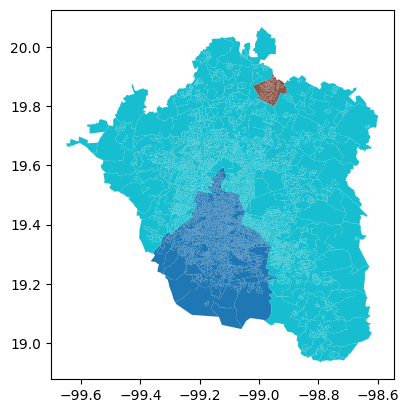

In [13]:
# Nos aseguramos que en efecto los polígonos en ZVM se corresponden con el 
# área que abarca la zona del valle de México
total_pol = gdf_R.copy()
total_pol["cve_agee"] = total_pol["cve_mun"].str[:2]

total_pol.plot(column="cve_agee")

In [14]:
# Información sobre la proyección utilizada 
joined.crs

<Derived Projected CRS: EPSG:4485>
Name: Mexico ITRF92 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Mexico between 114°W and 108°W, onshore and offshore.
- bounds: (-114.0, 15.09, -108.0, 32.27)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: Mexico ITRF92
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [15]:
joined = joined.drop(columns=["geometry", "index_right"])

In [16]:
# Se obtienen aquellos pings que lograron localizarse en algún polígono de la ZVM
# Estos son los pings registrados en la ZVM
# Los que no pertenecen a esa zona son descartados
pings_in_ZVM = duck.sql("""
SELECT *
FROM joined
WHERE cve_mun IS NOT NULL
""").df()

In [17]:
# Podemos ver que todos las zonas están representadas
len(pings_in_ZVM["cve_mun"].unique())

76

In [18]:
# Se obtiene H3 index a resolución 15 atribuido a los pings en la ZVM
pings_in_ZVM["h3index_15"] = pings_in_ZVM[["latitude", "longitude"]] \
    .apply(lambda x : h3.geo_to_h3(x["latitude"], x["longitude"], 15), axis=1)

In [19]:
pings_in_ZVM

,utc_timestamp,cdmx_datetime,caid,latitude,longitude,horizontal_accuracy,cve_zm,cve_mun,h3index_15
0,1578346604,2020-01-07 03:36:44+00:00,38b2d1fecd656d2a69e444dcc8550aa0984f159e08426d...,19.676037,-98.991331,128.9,09.01,15081,8f4995045a36b46
1,1578350144,2020-01-07 04:35:44+00:00,9779f1452cce0914eeffa2be05644e44c86990106367d0...,19.681130,-98.899210,104.0,09.01,15092,8f499505092a403
2,1578350709,2020-01-07 04:45:09+00:00,9779f1452cce0914eeffa2be05644e44c86990106367d0...,19.681130,-98.899210,110.0,09.01,15092,8f499505092a403
3,1578352727,2020-01-07 05:18:47+00:00,90288b8d5205f051a3c5739145cee49f10665b3419c801...,19.710913,-98.817723,116.1,09.01,15075,8f49950e3daec4d
4,1578352754,2020-01-07 05:19:14+00:00,becdf72416d1f0fa15e3ba2384dcdec494542d3de243ad...,19.591302,-99.025113,100.0,09.01,15033,8f499514949ca35
...,...,...,...,...,...,...,...,...,...
683745,1578410832,2020-01-07 21:27:12+00:00,94170a767dd818bc03d7e9592d549157cf183af24143e0...,19.431026,-99.090817,165.0,09.01,09017,8f4995bb348cd4b
683746,1578407040,2020-01-07 20:24:00+00:00,fb3df61322061119387373b93d492f774ca528489e1b44...,19.403640,-99.122484,118.0,09.01,09006,8f4995bb56a5a93
683747,1578410873,2020-01-07 21:27:53+00:00,f6c001d76b80c050d655060852d34f27462d7bce7fa224...,19.403325,-99.121485,165.0,09.01,09006,8f4995bb56a6d63
683748,1578411864,2020-01-07 21:44:24+00:00,95670856f6795e1a3af44d296cf473f046233324088793...,19.414576,-99.130556,200.0,09.01,09015,8f4995bb18ebc1e


### Calculo de interacciones

In [20]:
pings_base = duck.sql("""
WITH
pre AS (
    SELECT *
        , MIN(cdmx_datetime) OVER() AS min_datetime
    FROM pings_in_ZVM
)

, pings_base AS (
    SELECT *
        , TIME_BUCKET(INTERVAL '600 seconds', cdmx_datetime::TIMESTAMP, min_datetime::TIMESTAMP) AS tw
    FROM pre
)

SELECT *
FROM pings_base
""").df()

In [21]:
# Número de individuos distintos presentes en la tabla de pings
duck.sql("""
SELECT COUNT(DISTINCT caid)
FROM pings_base
""")

┌──────────────────────┐
│ count(DISTINCT caid) │
│        int64         │
├──────────────────────┤
│                99400 │
└──────────────────────┘

In [22]:
duck.sql("""
SELECT DISTINCT
    a.tw, a.h3index_15
    , a.caid AS a_caid, b.caid AS b_caid
FROM pings_base AS a
    INNER JOIN
    pings_base AS b
    ON a.h3index_15 = b.h3index_15
        AND a.tw = b.tw
WHERE a.caid != b.caid
""").write_parquet("../temp/interactions_table.parquet")

In [25]:
interactions_table = duck.sql("""
SELECT *
FROM read_parquet('../temp/interactions_table.parquet')
ORDER BY 1 ASC
""").df()

In [26]:
interactions_table

,tw,h3index_15,a_caid,b_caid
0,2020-01-07 00:00:00,8f4995881ad8983,a51c55c8847a073e63895a0bb6bd7e7d3f4a990ae5a981...,dbc86f244ce03cb313190f198fc1e7a609bf868ab2e3f6...
1,2020-01-07 00:00:00,8f4995a15cad9b5,8c4abf32bb4f83e5a9be9dd551ce9552c49e2881a1c665...,501e5bb4b239349d806a526de52fdba6c7ed99ff6dcc52...
2,2020-01-07 00:00:00,8f4995b1669b076,88906c6c37e1cc70e70233340b875782349b3c7a42ed14...,a4c2d44adb123e67e0346552b2c24dab0a2fdf614b15f2...
3,2020-01-07 00:00:00,8f49950292a26e8,d918bd4e8c53b3c1b919ff732c952064596966a59f204c...,497bec1a153c7cb19ef2668d3186c845acfe46ccd7ff26...
4,2020-01-07 00:00:00,8f49950292a26e8,588ee76adf55007700cce15e995a3bf82094b114c6da5b...,02ba9fb156afa0a2bf9a8633ca67d3dd67e1b773ab1829...
...,...,...,...,...
44403,2020-01-07 23:50:00,8f4995a13a5ad16,c8e3546fd919e726d56b2d8ddb237ec4b12f4ef5424ae9...,00b59248cded972503890f1527f5f1afdf2bfb043d75e0...
44404,2020-01-07 23:50:00,8f4995b3119aa0c,2a6126876812c5bdb533b9aa6a0fff35cb7c0848efbec1...,0ec967680b2439064982a8aeac45f30f2a61f6848643b2...
44405,2020-01-07 23:50:00,8f499584bc6b04b,a9ffd4fe66267843affcfa7dc0d84c3b525e39bdec83af...,01fdaa4cf7b034d78adc81b14e709079e33de0d90e937f...
44406,2020-01-07 23:50:00,8f4995b3119aa01,9b6295df193b4069585e68ebcfa42f842e410b68f9060c...,a7039566a1b14d0a77617e554a23bb039f9d4c2809a8a8...


In [37]:
no_caids_in_interactions = duck.sql("SELECT COUNT(DISTINCT a_caid) FROM interactions_table").fetchone()[0]
print(f"No. personas totales que interaccionan: {no_caids_in_interactions:,}")

No. personas totales que interaccionan: 6,535


In [29]:
# Conteo de interacciones netas 
# sin duplicados espejo, i.e., si a - b aparece entonces b - a se elimina
net_interactions = duck.sql("""
SELECT DISTINCT
    tw, h3index_15
    , CONCAT(LEAST(a_caid, b_caid), '-', GREATEST(a_caid, b_caid)) AS interactions
FROM interactions_table
ORDER BY 1 ASC
""").df()

In [30]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [31]:
net_interactions

,tw,h3index_15,interactions
0,2020-01-07 00:00:00,8f49950292a26e8,68413b60a18aaac33cc1d5ab2d241b2327d33bad5d3bede9d89914b4c15cb1b1-a1a3d5a3364e33bd66d16d2fc808d95e3bc99afb89ba3b8dc7ddd339b4ec26b8
1,2020-01-07 00:00:00,8f49950292a26ee,68413b60a18aaac33cc1d5ab2d241b2327d33bad5d3bede9d89914b4c15cb1b1-d918bd4e8c53b3c1b919ff732c952064596966a59f204c0ae8f3597a5f82709b
2,2020-01-07 00:00:00,8f499506a84c0ca,4ecaaf0fb9b87dc220fdc310d6780775ac86347640ec2aa1633eaec1dbaa73af-5f1eac6d75347c8fc9b7537c889c563f0a7cd4c9cebf8542d8ae8db2aedf6e7e
3,2020-01-07 00:00:00,8f4995a15cad9b5,501e5bb4b239349d806a526de52fdba6c7ed99ff6dcc52d33a22355dffa0d790-8c4abf32bb4f83e5a9be9dd551ce9552c49e2881a1c665981b86bae1babec9fd
4,2020-01-07 00:00:00,8f499584d42b149,85cae3f93536c9cb4f4fd5a737785d73eb5e219e2a181451f5e6e58565e2f0e8-c5ecdbe940282b1004bdabd38ee2ab5d67c2e4b4f0bc2b6d4030872f45e844fc
...,...,...,...
22199,2020-01-07 23:50:00,8f4995859a95b84,5a3526c73393f4aff807933a77a0aff19fa2424ffc56419724018ff5397dc0be-7f73ae3cad8b7be127843445aa36a76105d8ef9488c0a32e9c7307f20b9efd5e
22200,2020-01-07 23:50:00,8f499584bc6b04b,01fdaa4cf7b034d78adc81b14e709079e33de0d90e937f93e75df1a556d01cf1-a9ffd4fe66267843affcfa7dc0d84c3b525e39bdec83afbc95e9ce87321d023b
22201,2020-01-07 23:50:00,8f4995a13a5ad16,00b59248cded972503890f1527f5f1afdf2bfb043d75e0870824534df7d27e6b-dd9f2898796def72504fa9829e34473b7563261f832854c96e41a4c185f78142
22202,2020-01-07 23:50:00,8f4995168699b19,46fae6cba279c961028e89329b631124784836c486ce0615f79a4f9364e1f301-7372185b10c9cb18ad2ea1f47d9c539862c91ed91f1a9ab36dfe9be237a238d4


In [32]:
pd.reset_option("display.max_colwidth")

In [41]:
no_net_interactions = duck.sql("SELECT COUNT(*) FROM net_interactions").fetchone()[0]
print(f"No. totales de interacciones en la ZVM el {YEAR}-{MONTH}-{DAY}: {no_net_interactions:,}")

No. totales de interacciones en la ZVM el 2020-01-07: 22,204
